In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importaciones
import random, os, shutil
import imageio
import cv2
import numpy as np
import PIL

In [3]:
from zipfile import ZipFile 
file_name = '/content/drive/My Drive/Colab Notebooks/Ai Lab School/EJERCICIOS/Weather_Classification.zip'
with ZipFile(file_name, 'r') as zip_original: 
  zip_original.extractall('/content/')

In [4]:
train_dir = os.path.join('Weather_Classification/Training')
validation_dir = os.path.join('Weather_Classification/Validation')

In [5]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3)) # input_shape = (largo, ancho, canales)

conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

In [6]:
for layer in conv_base.layers:
    if layer.name[:6] == 'block5': 
      layer.trainable = True
    else:
      layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(conv_base)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())    #Normalizar los pesos aprendidos hasta este punto
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 2, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 14,724,932
Trainable params: 7,088,644
Non-trainable params: 7,636,288
_________________________________________________________________


In [9]:
from tensorflow.keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc']) #'acc' -> accuracy -> precisión

In [10]:
#Using ImageDataGenerator to read images from directories
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # Target directory
        target_size=(128, 128), # All images are resized from 240x320 to 72x96
        batch_size= 10, 
        color_mode='rgb',
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        batch_size=1,
        color_mode='rgb',
        class_mode='categorical')

Found 600 images belonging to 4 classes.
Found 523 images belonging to 4 classes.


In [11]:
#Training and validation stages
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor= 'val_acc', mode='max', patience = 500, verbose=1)
mc = ModelCheckpoint('/content/model1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(
      train_generator,
      steps_per_epoch=60, #70
      epochs= 20,
      validation_data=validation_generator,
      validation_steps=523,
      callbacks= [es, mc])

Epoch 1/20
60/60 [==============================] - 46s 219ms/step - loss: 0.4751 - acc: 0.8217 - val_loss: 0.3166 - val_acc: 0.9235

Epoch 00001: val_acc improved from -inf to 0.92352, saving model to /content/model1.h5
Epoch 2/20
60/60 [==============================] - 12s 209ms/step - loss: 0.0746 - acc: 0.9833 - val_loss: 0.2098 - val_acc: 0.9369

Epoch 00002: val_acc improved from 0.92352 to 0.93690, saving model to /content/model1.h5
Epoch 3/20
60/60 [==============================] - 13s 214ms/step - loss: 0.0307 - acc: 0.9900 - val_loss: 0.3005 - val_acc: 0.8929

Epoch 00003: val_acc did not improve from 0.93690
Epoch 4/20
60/60 [==============================] - 12s 204ms/step - loss: 0.0231 - acc: 0.9950 - val_loss: 0.2390 - val_acc: 0.9254

Epoch 00004: val_acc did not improve from 0.93690
Epoch 5/20
60/60 [==============================] - 12s 203ms/step - loss: 0.0092 - acc: 0.9983 - val_loss: 0.1995 - val_acc: 0.9369

Epoch 00005: val_acc did not improve from 0.93690
Epo

# **Curvas de precisión y pérdida**

Best accuracy epoch :  11, Value :  1.0
Best loss epoch :  11, Value :  0.1532369256


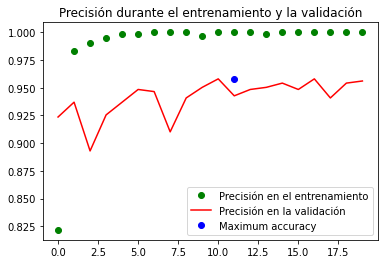

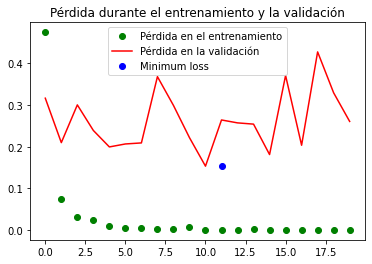

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
max_val_acc = max(val_acc)
max_val_acc_epoch= val_acc.index(max(val_acc)) + 1
loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Precisión en el entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Precisión en la validación')
plt.plot(max_val_acc_epoch, max_val_acc, 'bo', label='Maximum accuracy')
plt.title('Precisión durante el entrenamiento y la validación')
plt.legend()
print("Best accuracy epoch : % d, Value : % .1f" %(max_val_acc_epoch, max_val_acc)) 
plt.figure()

plt.plot(epochs, loss, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Minimum loss')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print("Best loss epoch : % d, Value : % .10f" %(min_val_loss_epoch, min_val_loss))

plt.show()

# **Predicciones**

In [13]:
import os, shutil, imutils, random, cv2

classes_architectural = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
predictions = []
labels = []

for class_weather in classes_architectural:
  src_dir = '/content/Weather_Classification/Validation/{}/'.format(class_weather)
  lst1 = sorted(os.listdir(src_dir))

  for file_name in lst1:
    image_original = cv2.imread(src_dir + file_name, 1)
    image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
    image_original = cv2.resize(image_original, (128, 128))
    image_original = image_original / 255.0
    image_original = np.expand_dims(image_original, axis = 0)
    prediction = model.predict(image_original)
    predictions.append(np.argmax(prediction))
    if class_weather == 'Cloudy':
      label = 0
    elif class_weather == 'Rain':
      label = 1
    elif class_weather == 'Shine':
      label = 2
    elif class_weather == 'Sunrise':
      label = 3
    labels.append(label)

In [14]:
from sklearn.metrics import confusion_matrix
mcm = confusion_matrix(labels, predictions)
print(mcm)

[[144   1   3   2]
 [  1  61   1   1]
 [  8   1  89   4]
 [  0   0   2 205]]


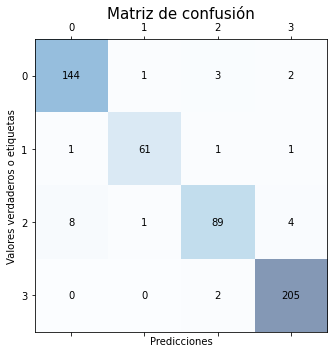

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(mcm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(mcm.shape[0]):
  for j in range(mcm.shape[1]):
      ax.text(x=j, y=i, s=mcm[i, j], va='center', ha='center')

plt.title("Matriz de confusión",fontsize=15)
#plt.title('f model: T= %d' % (t))
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos o etiquetas')

plt.tight_layout()
plt.show()